#Prédiction du flux net de carbone (NEE_VUT_REF) à partir de données météorologiques et écologiques en utilisant un LSTM sur le [dataset FLUXNET2015](https://fluxnet.org/data/fluxnet2015-dataset/)

In [66]:
# ========================================
# 1. Importation des bibliothèques
# ========================================
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [75]:
import os
import shutil
file_path = '/content/drive/MyDrive/Modele_DL/Datasets/FLX_US-Ha1_FLUXNET2015_FULLSET_HR_1991-2012_1-4.csv'

#Sauvegarde du contenu du jeu de données
#Si vous supprimez ce bloc d'instruction vous allez perdre le contenu du jeu de données original
#après modification

original_bak = file_path + '.bak'
# === Restauration automatique si une sauvegarde (.bak) existe déjà
if os.path.exists(original_bak):
    print(f" Une sauvegarde .bak existe déjà. Restauration dans le fichier original...\n")
    shutil.copy(original_bak, file_path)
    print(f"Fichier original restauré depuis la sauvegarde : {original_bak}\n")
else :
    shutil.copy(file_path,original_bak)
    print(f"Sauvegarde .bak effectuée du fichier original...\n")


# Chargement du CSV
df = pd.read_csv(file_path,skiprows=0)

# Aperçu des premières lignes
print(df.head())

# Taille du jeu de données
print("Shape: {df.shape}")

 Une sauvegarde .bak existe déjà. Restauration dans le fichier original...

Fichier original restauré depuis la sauvegarde : /content/drive/MyDrive/Modele_DL/Datasets/FLX_US-Ha1_FLUXNET2015_FULLSET_HR_1991-2012_1-4.csv.bak

   TIMESTAMP_START  TIMESTAMP_END  TA_F_MDS  TA_F_MDS_QC  TA_ERA    TA_F  \
0     199101010000   199101010100   -9999.0        -9999 -10.416 -10.416   
1     199101010100   199101010200   -9999.0        -9999 -10.959 -10.959   
2     199101010200   199101010300   -9999.0        -9999 -11.501 -11.501   
3     199101010300   199101010400   -9999.0        -9999 -11.677 -11.677   
4     199101010400   199101010500   -9999.0        -9999 -11.852 -11.852   

   TA_F_QC  SW_IN_POT  SW_IN_F_MDS  SW_IN_F_MDS_QC  ...  GPP_DT_CUT_MEAN  \
0        2        0.0          0.0               0  ...              0.0   
1        2        0.0          0.0               0  ...              0.0   
2        2        0.0          0.0               0  ...              0.0   
3        2     

Date de début: TIMESTAMP_START

Flux net d’échange de carbone (cible) : NEE_VUT_REF (ou parfois NEE_VUT_MEAN)

Météo :

* TA_F : température de l'air

* SW_IN_F : rayonnement solaire

* VPD_F : déficit de pression de vapeur

* P_F : précipitations

* RH ou RH_F : humidité relative

In [24]:
# Sélection de colonnes utiles
columns = ['TIMESTAMP_START', 'NEE_VUT_REF', 'TA_F', 'SW_IN_F', 'VPD_F', 'P_F']
df = df[columns]

# Convertir la date
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M')

# Mise en index temporel
df.set_index('TIMESTAMP', inplace=True)

# Affichage
print(df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192864 entries, 1991-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TIMESTAMP_START  192864 non-null  int64  
 1   NEE_VUT_REF      192864 non-null  float64
 2   TA_F             192864 non-null  float64
 3   SW_IN_F          192864 non-null  float64
 4   VPD_F            192864 non-null  float64
 5   P_F              192864 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 10.3 MB
None


In [25]:
print(df.columns)

Index(['TIMESTAMP_START', 'NEE_VUT_REF', 'TA_F', 'SW_IN_F', 'VPD_F', 'P_F'], dtype='object')


Données journalier

In [27]:
# Définir l'agrégation pour chaque colonne
agg_dict = {
    'NEE_VUT_REF': 'mean',
    'TA_F': 'mean',
    'SW_IN_F': 'mean',
    'VPD_F': 'mean',
    'P_F': 'sum'  # somme des précipitations sur la journée
}

# Grouper par jour
df_daily = df.resample('D').agg(agg_dict)

# Supprimer les jours incomplets (valeurs manquantes)
df_daily = df_daily.dropna()

# Aperçu des données journalières
print(df_daily.head())


            NEE_VUT_REF      TA_F    SW_IN_F     VPD_F    P_F
TIMESTAMP                                                    
1991-01-01     0.692614 -6.990000  79.870750  2.333167  0.000
1991-01-02     0.694167 -5.431875  60.493125  2.354792  0.000
1991-01-03     0.637174 -2.983167  75.393750  2.596708  0.000
1991-01-04     0.692614 -0.848917  63.634542  2.806292  0.000
1991-01-05     0.694167  2.523000  43.628250  2.893250  0.438


In [29]:
print(df_daily.columns)

Index(['NEE_VUT_REF', 'TA_F', 'SW_IN_F', 'VPD_F', 'P_F'], dtype='object')


In [56]:
import numpy as np

def create_sequences(data, target_col, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data.iloc[i:i+window_size].values
        target = data.iloc[i+window_size][target_col]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

# Normalisation avant de créer les séquences
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(df_daily), columns=df_daily.columns, index=df_daily.index)

# 2. Conserver une copie non normalisée de NEE pour la dénormalisation plus tard
scaler_nee = MinMaxScaler()
nee_original = df_daily[['NEE_VUT_REF']]
scaler_nee.fit(nee_original)

# Création des séquences
window_size=30 # jour = 30
target_col='NEE_VUT_REF'
X, y = create_sequences(scaled_data, target_col, window_size)

print("X shape :", X.shape)  # (samples, window_size, features)
print("y shape :", y.shape)  # (samples,)


X shape : (8006, 30, 5)
y shape : (8006,)


In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # pas de shuffle en séries temporelles !
)


In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Dimensions
n_timesteps = X.shape[1]   # ex: 7
n_features = X.shape[2]    # ex: 5

# Définition du modèle
model = Sequential([
    LSTM(64, input_shape=(n_timesteps, n_features), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  # Sortie : prédiction de NEE
])

# Compilation
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


# Résumé
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Entraînement
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0125 - mae: 0.0726 - val_loss: 0.0028 - val_mae: 0.0370
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0020 - mae: 0.0297 - val_loss: 0.0025 - val_mae: 0.0320
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0021 - mae: 0.0302 - val_loss: 0.0023 - val_mae: 0.0298
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0024 - val_mae: 0.0314
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0019 - mae: 0.0286 - val_loss: 0.0024 - val_mae: 0.0340
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0017 - mae: 0.0272 - val_loss: 0.0025 - val_mae: 0.0351
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0019 - mae: 0.0283 - val_loss: 0.0028 - val_mae: 0.0364
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0019 - mae: 0.0283 - val_loss: 0.0024 - val_mae: 0.0333
Epoch 9/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/

Evaluation du modèle

In [69]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Erreur MAE sur les données de test : {mae:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mae: 0.0325
Erreur MAE sur les données de test : 0.0366


Prédiction

In [70]:
y_pred = model.predict(X_test)
#inverser la normalisation
y_test_real = scaler_nee.inverse_transform(y_test.reshape(-1, 1))
y_pred_real = scaler_nee.inverse_transform(y_pred)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Visualisation des résultats

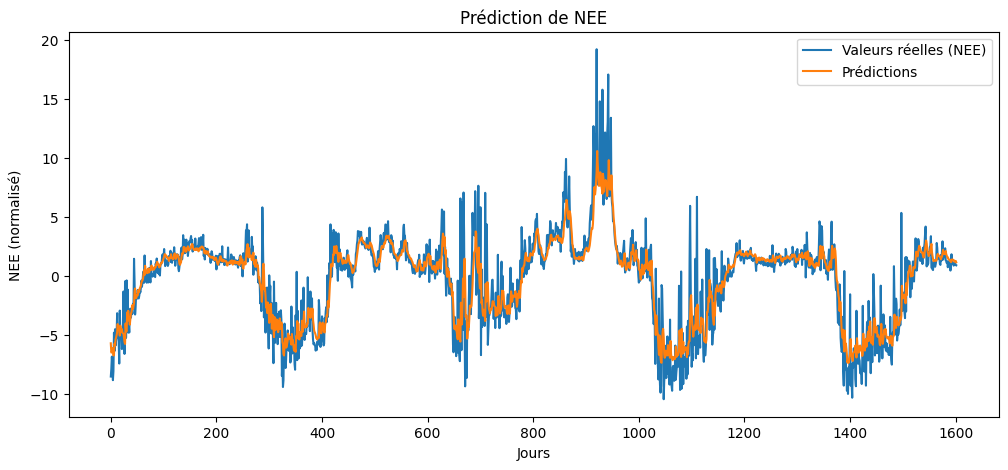

In [63]:
import matplotlib.pyplot as plt

# Comparaison
plt.figure(figsize=(12, 5))
plt.plot(y_test_real, label='Valeurs réelles (NEE)')
plt.plot(y_pred_real, label='Prédictions')
plt.title("Prédiction de NEE")
plt.xlabel("Jours")
plt.ylabel("NEE (normalisé)")
plt.legend()
plt.show()


In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("MAE :", mean_absolute_error(y_test_real, y_pred_real))
print("RMSE:", np.sqrt(mean_squared_error(y_test_real, y_pred_real)))
print("R²  :", r2_score(y_test_real, y_pred_real))



MAE : 1.1540317981543928
RMSE: 1.805493986524914
R²  : 0.7846263603532859


Test manuel

In [65]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# ================================
# 1. Définir les colonnes utilisées dans le modèle
# ================================
feature_cols = ['NEE_VUT_REF', 'TA_F', 'SW_IN_F', 'VPD_F', 'P_F']

# ================================
# 2. Normalisation globale
# ================================
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(
    scaler.fit_transform(df_daily[feature_cols]),
    columns=feature_cols,
    index=df_daily.index
)

# Normalisation séparée pour dénormaliser la prédiction de NEE
scaler_nee = MinMaxScaler()
scaler_nee.fit(df_daily[['NEE_VUT_REF']])

# ================================
# 3. Créer la séquence des 7 derniers jours réels
# ================================
last_7_days = scaled_data[-7:].values  # shape: (7, 5)

# Reshape au format attendu par LSTM : (1, 7, 5)
input_sequence = np.array(last_7_days).reshape((1, 7, 5))

# ================================
# 4. Prédiction
# ================================
pred_scaled = model.predict(input_sequence)
print("Valeur prédite (échelle normalisée) :", pred_scaled)

# ================================
# 5. Dénormalisation
# ================================
pred_real = scaler_nee.inverse_transform(pred_scaled)
print("Valeur prédite (réelle, NEE µmol CO₂ m⁻² s⁻¹) :", pred_real[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Valeur prédite (échelle normalisée) : [[0.4229553]]
Valeur prédite (réelle, NEE µmol CO₂ m⁻² s⁻¹) : 0.9851092
